In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, LeakyReLU
from keras.layers.noise import AlphaDropout
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.optimizers import Adam

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
def preprocess_mnist(x_train, y_train, x_test, y_test):
    # Normalizing all images of 28x28 pixels
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)
    
    # Float values for division
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    
    # Normalizing the RGB codes by dividing it to the max RGB value
    x_train /= 255
    x_test /= 255
    
    # Categorical y values
    y_train = to_categorical(y_train)
    y_test= to_categorical(y_test)
    
    return x_train, y_train, x_test, y_test, input_shape
    
x_train, y_train, x_test, y_test, input_shape = preprocess_mnist(x_train, y_train, x_test, y_test)

In [4]:
def build_cnn(activation,
              dropout_rate,
              optimizer):
    model = Sequential()
    
    if(activation == 'selu'):
        model.add(Conv2D(32, kernel_size=(3, 3),
                  activation=activation,
                  input_shape=input_shape,
                  kernel_initializer='lecun_normal'))
        model.add(Conv2D(64, (3, 3), activation=activation, 
                         kernel_initializer='lecun_normal'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(AlphaDropout(0.25))
        model.add(Flatten())
        model.add(Dense(128, activation=activation, 
                        kernel_initializer='lecun_normal'))
        model.add(AlphaDropout(0.5))
        model.add(Dense(10, activation='softmax'))
    else:
        model.add(Conv2D(32, kernel_size=(3, 3),
                  activation=activation,
                  input_shape=input_shape))
        model.add(Conv2D(64, (3, 3), activation=activation))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(128, activation=activation))
        model.add(Dropout(0.5))
        model.add(Dense(10, activation='softmax'))
    
    model.compile(
        loss='binary_crossentropy', 
        optimizer=optimizer, 
        metrics=['accuracy']
    )
    
    return model

In [5]:
# Add the GELU function to Keras
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))
get_custom_objects().update({'gelu': Activation(gelu)})

# Add leaky-relu so we can use it as a string
get_custom_objects().update({'leaky-relu': Activation(LeakyReLU(alpha=0.2))})

act_func = ['sigmoid', 'relu', 'elu', 'leaky-relu', 'selu', 'gelu']

In [6]:
result = []

for activation in act_func:
    print('\nTraining with -->{0}<-- activation function\n'.format(activation))
    
    model = build_cnn(activation=activation,
                      dropout_rate=0.2,
                      optimizer=Adam(clipvalue=0.5))
    
    history = model.fit(x_train, y_train,
          validation_split=0.20,
          batch_size=128, # 128 is faster, but less accurate. 16/32 recommended
          epochs=30,
          verbose=1,
          validation_data=(x_test, y_test))
    
    result.append(history)
    
    K.clear_session()
    del model

print(result)


Training with -->sigmoid<-- activation function

Epoch 1/30
375/375 [==============================] - 110s 295ms/step - loss: 0.3376 - accuracy: 0.1007 - val_loss: 0.3252 - val_accuracy: 0.1060
Epoch 2/30
375/375 [==============================] - 105s 280ms/step - loss: 0.3271 - accuracy: 0.1011 - val_loss: 0.3252 - val_accuracy: 0.0995
Epoch 3/30
375/375 [==============================] - 106s 282ms/step - loss: 0.3255 - accuracy: 0.1040 - val_loss: 0.3251 - val_accuracy: 0.1060
Epoch 4/30
375/375 [==============================] - 107s 285ms/step - loss: 0.3253 - accuracy: 0.1067 - val_loss: 0.3252 - val_accuracy: 0.1060
Epoch 5/30
375/375 [==============================] - 108s 287ms/step - loss: 0.3252 - accuracy: 0.1080 - val_loss: 0.3251 - val_accuracy: 0.0998
Epoch 6/30
375/375 [==============================] - 108s 287ms/step - loss: 0.3252 - accuracy: 0.1080 - val_loss: 0.3252 - val_accuracy: 0.1060
Epoch 7/30
375/375 [==============================] - 107s 286ms/step - lo

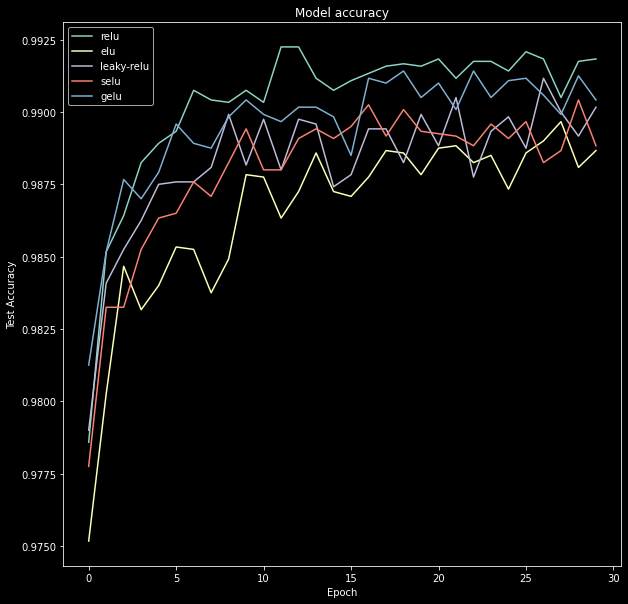

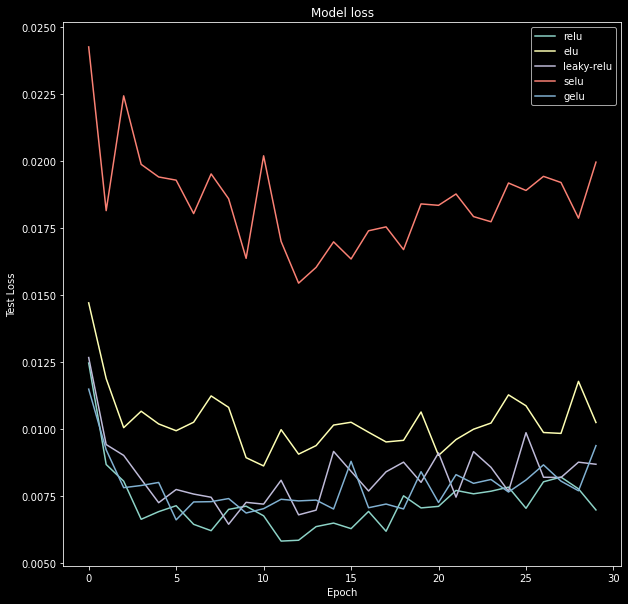

In [8]:
new_act_arr = act_func[1:]
new_results = result[1:]

def plot_act_func_results(results, activation_functions = []):
    plt.figure(figsize=(10,10))
    plt.style.use('dark_background')
    
    # Plot validation accuracy values
    for act_func in results:
        plt.plot(act_func.history['val_accuracy'])
        
    plt.title('Model accuracy')
    plt.ylabel('Test Accuracy')
    plt.xlabel('Epoch')
    plt.legend(activation_functions)
    plt.show()

    # Plot validation loss values
    plt.figure(figsize=(10,10))
    
    for act_func in results:
        plt.plot(act_func.history['val_loss'])
        
    plt.title('Model loss')
    plt.ylabel('Test Loss')
    plt.xlabel('Epoch')
    plt.legend(activation_functions)
    plt.show()

plot_act_func_results(new_results, new_act_arr)